Example extracted from [https://www.geeksforgeeks.org/deep-learning/generative-adversarial-network-gan/](https://www.geeksforgeeks.org/deep-learning/generative-adversarial-network-gan/)

## 1. Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Defining Image Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 3. Loaging the CIFAR-10 Dataset

In [ ]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:16<00:00, 10.5MB/s]


## 4. Defining GAN Hyperparameters

Set important training parameters:

- **latent_dim**: Dimensionality of the noise vector.
- **lr**: Learning rate of the optimizer.
- **beta1**, **beta2**: Beta parameters for Adam optimizer (e.g 0.5, 0.999)
- **num_epochs**: Number of times the entire dataset will be processed (e.g 10)

In [ ]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 30

## 5. Building the Generator

Create a neural network that converts random noise into images. Use transpose convolutional layers, batch normalization and ReLU activations. The final layer uses Tanh activation to scale outputs to the range [-1, 1].

- **nn.Linear(latent_dim, 128 * 8 * 8)**: Defines a fully connected layer that projects the noise vector into a higher dimensional feature space.
- **nn.Upsample(scale_factor=2)**: Doubles the spatial resolution of the feature maps by upsampling.
- **nn.Conv2d(128, 128, kernel_size=3, padding=1)**: Applies a convolutional layer keeping the number of channels the same to refine features.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

## 6. Building the Discriminator

Create a binary classifier network that distinguishes real from fake images. Use convolutional layers, batch normalization, dropout, LeakyReLU activation and a Sigmoid output layer to give a probability between 0 and 1.

- **nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)**: Second convolutional layer increasing channels to 64, downsampling further.
- **nn.BatchNorm2d(256, momentum=0.8)**: Batch normalization for 256 feature maps with momentum 0.8.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

## 7. Initializing

- Generator and Discriminator are initialized on the available device (GPU or CPU).
- Binary Cross-Entropy (BCE) Loss is chosen as the loss function.
- Adam optimizers are defined separately for the generator and discriminator with specified learning rates and betas.

In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

## 8. Training

Train the discriminator on real and fake images, then update the generator to improve its fake image quality. Track losses and visualize generated images after each epoch.

- **valid = torch.ones(real_images.size(0), 1, device=device)**: Create a tensor of ones representing real labels for the discriminator.
- **fake = torch.zeros(real_images.size(0), 1, device=device)**: Create a tensor of zeros representing fake labels for the discriminator.
- **z = torch.randn(real_images.size(0), latent_dim, device=device)**: Generate random noise vectors as input for the generator.
- **g_loss = adversarial_loss(discriminator(gen_images), valid)**: Calculate generator loss based on the discriminator classifying fake images as real.
- **grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)**: Arrange generated images into a grid for display, normalizing pixel values.

Epoch [1/30]                        Batch 100/1563 Discriminator Loss: 0.6310 Generator Loss: 1.0856
Epoch [1/30]                        Batch 200/1563 Discriminator Loss: 0.7243 Generator Loss: 1.0722
Epoch [1/30]                        Batch 300/1563 Discriminator Loss: 0.7337 Generator Loss: 1.1005
Epoch [1/30]                        Batch 400/1563 Discriminator Loss: 0.6917 Generator Loss: 1.1717
Epoch [1/30]                        Batch 500/1563 Discriminator Loss: 0.5310 Generator Loss: 1.1474
Epoch [1/30]                        Batch 600/1563 Discriminator Loss: 0.7355 Generator Loss: 0.8708
Epoch [1/30]                        Batch 700/1563 Discriminator Loss: 0.6745 Generator Loss: 1.2315
Epoch [1/30]                        Batch 800/1563 Discriminator Loss: 0.7858 Generator Loss: 0.8245
Epoch [1/30]                        Batch 900/1563 Discriminator Loss: 0.6330 Generator Loss: 0.9612
Epoch [1/30]                        Batch 1000/1563 Discriminator Loss: 0.6853 Generator Lo

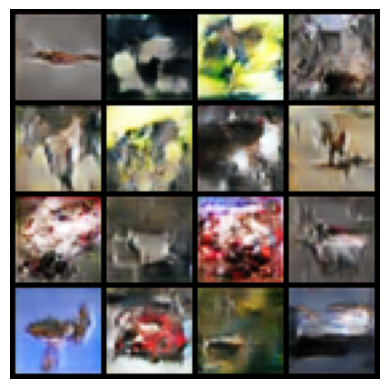

Epoch [11/30]                        Batch 100/1563 Discriminator Loss: 0.6146 Generator Loss: 1.1872
Epoch [11/30]                        Batch 200/1563 Discriminator Loss: 0.7205 Generator Loss: 1.0533
Epoch [11/30]                        Batch 300/1563 Discriminator Loss: 0.6223 Generator Loss: 1.1095
Epoch [11/30]                        Batch 400/1563 Discriminator Loss: 0.5828 Generator Loss: 0.7897
Epoch [11/30]                        Batch 500/1563 Discriminator Loss: 0.5107 Generator Loss: 1.1712
Epoch [11/30]                        Batch 600/1563 Discriminator Loss: 0.5452 Generator Loss: 1.1918
Epoch [11/30]                        Batch 700/1563 Discriminator Loss: 0.4733 Generator Loss: 1.6043
Epoch [11/30]                        Batch 800/1563 Discriminator Loss: 0.6569 Generator Loss: 1.1823
Epoch [11/30]                        Batch 900/1563 Discriminator Loss: 0.7731 Generator Loss: 0.9131
Epoch [11/30]                        Batch 1000/1563 Discriminator Loss: 0.7283 Ge

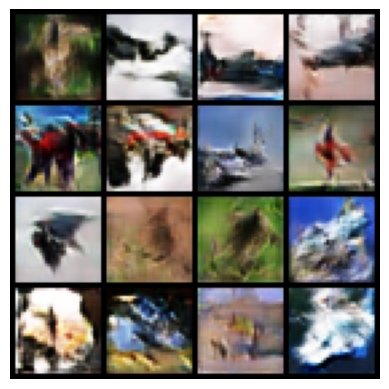

Epoch [21/30]                        Batch 100/1563 Discriminator Loss: 0.6704 Generator Loss: 0.9994
Epoch [21/30]                        Batch 200/1563 Discriminator Loss: 0.4294 Generator Loss: 1.6680
Epoch [21/30]                        Batch 300/1563 Discriminator Loss: 0.3051 Generator Loss: 1.7558
Epoch [21/30]                        Batch 400/1563 Discriminator Loss: 0.5725 Generator Loss: 1.0703
Epoch [21/30]                        Batch 500/1563 Discriminator Loss: 0.5754 Generator Loss: 0.8874
Epoch [21/30]                        Batch 600/1563 Discriminator Loss: 0.5921 Generator Loss: 0.9687
Epoch [21/30]                        Batch 700/1563 Discriminator Loss: 0.3578 Generator Loss: 2.0567
Epoch [21/30]                        Batch 800/1563 Discriminator Loss: 0.3976 Generator Loss: 1.6124
Epoch [21/30]                        Batch 900/1563 Discriminator Loss: 0.5874 Generator Loss: 1.4437
Epoch [21/30]                        Batch 1000/1563 Discriminator Loss: 0.3392 Ge

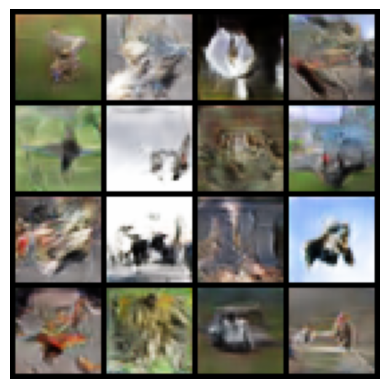

In [ ]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):

        real_images = batch[0].to(device)

        # Create a tensor of ones representing real labels for the discriminator.
        valid = torch.ones(real_images.size(0), 1, device=device)
        # Create a tensor of zeros representing fake labels for the discriminator.
        fake = torch.zeros(real_images.size(0), 1, device=device)

        real_images = real_images.to(device)

        optimizer_D.zero_grad()

        # Generate random noise vectors as input for the generator.
        z = torch.randn(real_images.size(0), latent_dim, device=device)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        # Calculate generator loss based on the discriminator classifying fake images as real.
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            # Arrange generated images into a grid for display, normalizing pixel values.
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

plt.close()